# Analysis of the Netflix catalogue
## Visualization, data mining and prediction of data
This notebook contains the results by using the aformentioned techniques in order to get an understanding of how the netflix catalogue has evolved over the years as well as representing the data in an understandable manner.

Most of the python code that does the heavy lifting i.e data sanitizing, crunching of numbers and magic resides in seperate .py files in order to keep the notbook clean, only featuring code that is relevant for plot and other visualization.



# Python setup
We recommend opening this notebook using JupyterLab in order to be able to view all the interactive plots.

NB! Please only run this one time as the change director command will keep moving the notebook directory up the directory tree, this causes the filepath defined in the code to not agree with the current directory of the notebook. Restart kernel if IOError occurs. 



In [ ]:
# Only run this cell one time. Restart kernel and run again to fix IOError.
import os
import yrs_months

# Changes the notebook working directory on level up.
%cd ..

# Running main python script.
%run -i "src/main.py"

# Data set from main.py
data_set

# Chapter 1. Genre analysis

## Most Popular movie and series genres
### Discarding the 'movie' and 'tv show'  entry in the genre list and 

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (15,15))
plt.pie(
    [genre_value for genre_value in pop_movie_genre.values()],
    labels=[genre_keys for genre_keys in pop_movie_genre.keys()],
    autopct=None
)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (15,15))
plt.pie(
    [genre_value for genre_value in pop_series_genre.values()],
    labels=[genre_keys for genre_keys in pop_series_genre.keys()],
    autopct=None
)
plt.show()


# Classifying directors  from heatmap.

### Creating director - genre matrix

In [ ]:
populated = director_classification.populate_director_genre_dataframe()

In [ ]:
import copy
import seaborn as sns

# Copying dataframe in order to not directly mutating the populated list
# as it takes some time to create the populatedDirector list
copy = copy.copy(populated)

for d in copy:
    # Dropping directors columns that has less that 8 registered movies in total in addition to unknown director.
    if (copy[d].sum() < 8.0 or d == 'Unknown director'):
        copy.drop([d],  axis=1, inplace = True)

sns.heatmap(copy) # Creating heatmap
plt.show()

From this heatmap containing the most active directors in the Netflix catalogue we can "classify" which genre a certain director is. By analysing the heatmap we can clearly state that "Stand-Up Comedy" is the genre that director is most active in and that Jan Suter is a "Stand-Up Comedy" director. McG can be with some certanty be classified as a "Action & Adventure" director.

# Genres added per year (Sander)
## The following plots shows the frequency of when genres were added

In [ ]:
import pandas as pd
import numpy as np
import correlation_between_genres
import matplotlib.pyplot as plt
import chord

df = pd.DataFrame(pd.read_csv('netflix_titles.csv'))
dfMovies = df[df['type'] == 'Movie']
dfSeries = df[df['type'] == 'TV Show']

# Handling null values
### Number of movies and series which have missing date for when they were added.

In [ ]:
missingMovieDates = len(dfMovies[dfMovies['date_added'].isnull()])
missingSeriesDates = len(dfSeries[dfSeries['date_added'].isnull()])
print('Total number of movies having a unknown date they were added: ', missingMovieDates)
print('Total number of series having a unknown date they were added: ', missingSeriesDates)

In [ ]:
def genresAddedPerYear(df: pd.DataFrame) -> pd.DataFrame:
    # Gets the dates from the dateFrame and converts the format to datetime
    dates = pd.to_datetime(df['date_added'])
    # Removes day and month, as we are only interested in the year
    dates = dates.dt.year


    # Splits the listed_in column into individual genre columns
    genres = correlation_between_genres.genresOfMoviesSeries(df)

    # Puts dates and genres into one table
    genreAdded = correlation_between_genres.genresOfMoviesSeries(df)
    genreAdded.insert(0, 'date_added', dates)

    # Change cells with no value to None
    genreAdded = genreAdded.where(genreAdded.notnull(), None)

    # Name of every genre
    uniqueGenres = correlation_between_genres.totalOccurenceOfGenres(genres).keys().tolist()
    uniqueYears = genreAdded['date_added'].unique()
    # Flip the list to get the columns in the next step in ascending order from left to right
    uniqueYears = np.flip(uniqueYears)
    # Removing nan value
    uniqueYears = uniqueYears[1:]
    uniqueYears = np.sort(uniqueYears)

    genresAddedPerYear = pd.DataFrame(0, index = uniqueGenres, columns=uniqueYears)


    for i, movie in genreAdded.iterrows():
        yearAdded = movie['date_added']
        genresOfMovie = movie[1:4]

        for genre in genresOfMovie:
            if (yearAdded == None or genre == None):
                continue
            genresAddedPerYear[yearAdded][genre] += 1
    
    return genresAddedPerYear

### DataFrame showing how many movies/series with a given genre was added per year. Mind that a movie/series may have multiple genres and the sum of each column isn't the same as at number of movies/series added per year.

In [ ]:
genresAddedPerYearSeries = genresAddedPerYear(dfSeries)
genresAddedPerYearMovies = genresAddedPerYear(dfMovies)

### Removing the data in the year 2020 as the year is not over yet and therefore is not representable

In [ ]:
genresAddedPerYearSeries = genresAddedPerYearSeries.drop(2020, axis = 'columns')
genresAddedPerYearMovies = genresAddedPerYearMovies.drop(2020, axis = 'columns')

### Displaying DataFrames

In [ ]:
display(genresAddedPerYearSeries)
display(genresAddedPerYearMovies)

# Visualizing the data

In [ ]:
movieGenres = genresAddedPerYearMovies.index
seriesGenres = genresAddedPerYearSeries.index

fig, (ax1, ax2) = plt.subplots(1, 2, )
fig.subplots_adjust(right = 2, top = 1)

ax1.set_xlabel('Years')
ax1.set_ylabel('Added to genre')
ax1.set_title('Movies added to genre per year', fontweight = 'bold')

ax2.set_xlabel('Years')
ax2.set_ylabel('Added to genre')
ax2.set_title('Series added to genre per year', fontweight = 'bold')



for genre in movieGenres:
    ax1.plot(genresAddedPerYearMovies.loc[genre], marker = '.')

for genre in seriesGenres:
    ax2.plot(genresAddedPerYearSeries.loc[genre], marker = '.')

ax1.legend(movieGenres, loc = 2, fontsize = 5)
ax2.legend(seriesGenres, loc = 2, fontsize = 5)
plt.show()

## Genres added per year
We can tell from these two plots that the amount of new content added has been increasing every year, and the growth started to spike around 2015. We can also tell that there hasn't been added any new series in the years between 2008 and 2012. There are in total 11 movies/series missing a added date where 10 of them are series. Some of these, or all, might have been added in the years between 2008 and 2012, but we don't really know.

In [ ]:
def genreCombos(df: pd.DataFrame) -> pd.DataFrame:
        # Genre of every movie/series
    genres = correlation_between_genres.genresOfMoviesSeries(df)

    # How many occurences a genre needs to have to be included in the data
    TOTAL_OCCURENCE_THRESHOLD = 100

    # How many times a genre occurs
    genreOccurence = correlation_between_genres.totalOccurenceOfGenres(genres)

    # Only keeping genres that has an occurence higher than the threshold
    genreOccurence = genreOccurence[genreOccurence > TOTAL_OCCURENCE_THRESHOLD]

    # Cross-section between genres
    corrMatrix = pd.DataFrame(index = genreOccurence.keys(), columns = genreOccurence.keys())

    # Filling corrMatrix with values
    for genre1 in corrMatrix.keys():
        for genre2 in corrMatrix.keys():
            mainGenre = correlation_between_genres.moviesSeriesWithGenre(genres, genre1)
            genreCombination = correlation_between_genres.moviesSeriesWithGenre(mainGenre, genre2)

            if(genre1 == genre2):
                corrMatrix[genre1][genre2] = 0
            else:
                corrMatrix[genre1][genre2] = len(genreCombination)
                
    return corrMatrix

### Combination of genres in movies
NB! As mentioned before in order to show this plot open in JupyterLab.

In [ ]:
moviesGenreCombos = genreCombos(dfMovies)

# Converts the cross-section matrix to a list as it is needed it the next step.
genreCombinationValues = moviesGenreCombos.values.tolist()
genreNames = moviesGenreCombos.index.tolist()

# NOTE: Requires to be run in jupyter lab as the plot won't show in notebook.
chord.Chord(genreCombinationValues, genreNames, margin=80, font_size_large='10px').show()

### Combination of genres in movies
NB! As mentioned before in order to show this plot open in JupyterLab.

In [ ]:
moviesGenreCombos = genreCombos(dfSeries)

# Converts the cross-section matrix to a list as it is needed it the next step.
genreCombinationValues = moviesGenreCombos.values.tolist()
genreNames = moviesGenreCombos.index.tolist()

# NOTE: Requires to be run in jupyter lab as the plot won't show in notebook.
chord.Chord(genreCombinationValues, genreNames, margin=80, font_size_large='10px').show()

## Chapter 1.2 - Patterns in genres (Aleksander)

In [ ]:
#Work with desired data
df = data_set[["type","date_added"]].copy()
df = yrs_months.valid_dates(df)
df

In [ ]:
#Get month and year columns
df = yrs_months.create_month_column(df)
df = yrs_months.create_year_column(df)
df

In [ ]:
months = yrs_months.all_months()
years = yrs_months.all_years()

In [ ]:
df = yrs_months.create_table(df)

In [ ]:
df

In [ ]:
yrs_months.heatmap(df,title="Content update per month and year",xlab="Month",ylab="Year")

In [ ]:
#Christmas
df_xmas = data_set[["date_added","description"]].copy()
df_xmas = df_xmas[df_xmas["description"].str.contains("Christmas")]
df_xmas 

In [ ]:
df_xmas = yrs_months.valid_dates(df_xmas) #Remova all dates with "Uknown date_added"
df_xmas = yrs_months.create_month_column(df_xmas) #Create month column
df_xmas = yrs_months.create_year_column(df_xmas) #Create year column
df_xmas

In [ ]:
df_xmas_tab = yrs_months.create_table(df_xmas)

In [ ]:
df_xmas_tab

In [ ]:
yrs_months.heatmap(df_xmas_tab,title="Overview of when Christmas content is added",xlab="Months",ylab="Years")

In [29]:
#Find all Horror related categories and see if more horror stuff comes before Halloween (should come in september/october)
df_horror = data_set[["date_added","listed_in"]].copy()
df_horror = df_horror[df_horror["listed_in"].str.contains("Horror")]

In [30]:
df_horror = yrs_months.valid_dates(df_horror)
df_horror = yrs_months.create_month_column(df_horror)
df_horror = yrs_months.create_year_column(df_horror)

In [31]:
df_horror

,date_added,listed_in,month,year
23,"September 8, 2017","Horror Movies, Thrillers",September,2017
29,"September 7, 2018","Horror Movies, International Movies",September,2018
49,"September 5, 2018","Horror Movies, International Movies",September,2018
50,"September 5, 2018","Horror Movies, International Movies",September,2018
56,"September 4, 2019",Horror Movies,September,2019
...,...,...,...,...
6130,"August 9, 2018","TV Dramas, TV Horror, TV Mysteries",August,2018
6185,"April 5, 2019","TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",April,2019
6193,"April 29, 2019","TV Action & Adventure, TV Comedies, TV Horror",April,2019
6195,"April 27, 2018","International TV Shows, TV Dramas, TV Horror",April,2018


In [32]:
df_horror_tab = yrs_months.create_table(df_horror)

In [33]:
df_horror_tab

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
2016,0.0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,3.0


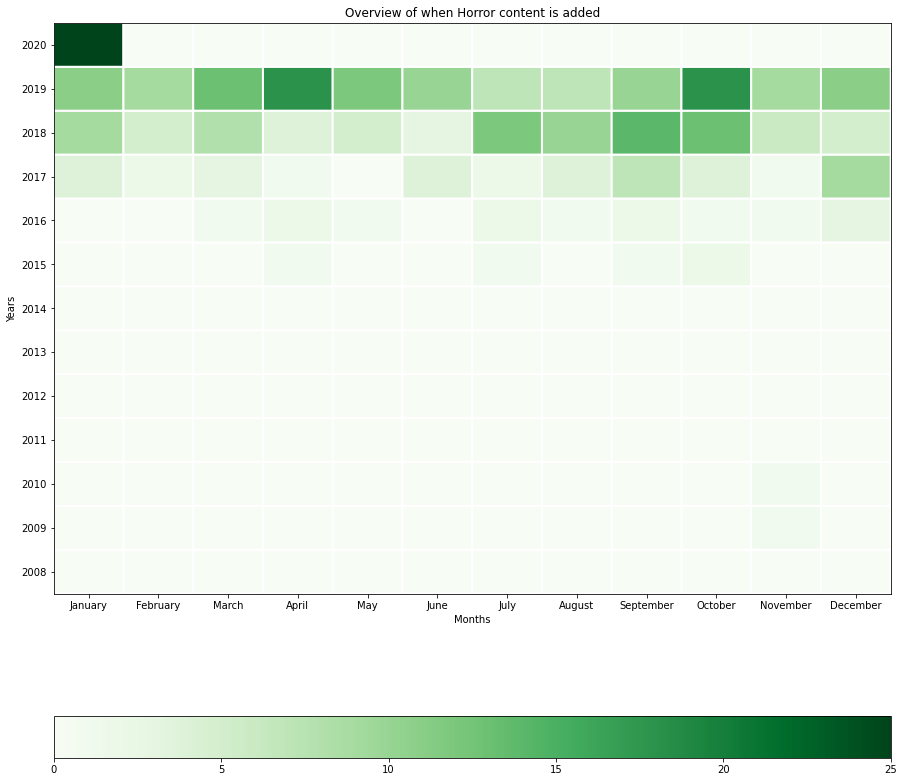

In [34]:
yrs_months.heatmap(df_horror_tab,title="Overview of when Horror content is added",xlab="Months",ylab="Years")

In [ ]:
#Love movies around valentines? should be added in jan/feb

#Find all Romantic related categories and see if more horror stuff comes before Halloween (should come in september/october)
df_romantic = data_set[["date_added","listed_in"]].copy()
df_romantic = df_romantic[df_romantic["listed_in"].str.contains("Romantic")]
df_romantic = yrs_months.valid_dates(df_romantic)
df_romantic = yrs_months.create_month_column(df_romantic)
df_romantic = yrs_months.create_year_column(df_romantic)
df_romantic_tab = yrs_months.create_table(df_romantic)

In [ ]:
yrs_months.heatmap(df_romantic_tab,title="sometitle",xlab="fksd",ylab="fonsd")

# Summary genre